In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import KNNImputer
import statsmodels.formula.api as smf
import statsmodels.api as sm

# Load the data

In [2]:
DATA_FOLDER = 'Data/'
HOUSEHOLD_DATASET = DATA_FOLDER+'PisoFirme_AEJPol-20070024_household.dta'
INDIVIDUAL_DATASET = DATA_FOLDER+'PisoFirme_AEJPol-20070024_individual.dta'

household = pd.read_stata(HOUSEHOLD_DATASET)
individual = pd.read_stata(INDIVIDUAL_DATASET)

In [3]:
household.head()

,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,C_blocksdirtfloor,C_HHdirtfloor,C_child05,C_households,...,S_cesds,S_pss,S_instcement,S_instsanita,S_restsanita,S_constceili,S_restowalls,S_improveany,S_logrent,S_logsell
0,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,14.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.903487
1,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,17.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,5.298317,9.615806
2,0.0,70000537.0,-103.50367,25.583067,7.0,40,0.3,0.036629,0.555554,819.0,...,16.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,6.214608,10.819778
3,0.0,70000537.0,-103.50367,25.583067,7.0,47,0.3,0.036629,0.555554,819.0,...,20.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,11.385092,11.918390
4,0.0,70000537.0,-103.50367,25.583067,7.0,47,0.3,0.036629,0.555554,819.0,...,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.703783,10.819778


In [4]:
print("We have ",len(household.index)," households.")
print("We have ", len(household.columns)," variables for households.")
print("How many missing values is there ? ", household.isna().sum().sum())

We have  2783  households.
We have  78  variables for households.
How many missing values is there ?  5786


In [5]:
individual.head()

,dpisofirme,idcluster,coord_x,coord_y,idmun,idmza,S_age,S_gender,S_childma,S_childmaage,...,S_milkprogram,S_foodprogram,S_seguropopular,S_hasanimals,S_animalsinside,S_garbage,S_washhands,S_incomepc,S_cashtransfers,S_assetspc
0,0.0,70000537.0,-103.50367,25.583067,7.0,47,1.0,0,1.0,27.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.000000,0.0,21158.214844
1,0.0,70000537.0,-103.50367,25.583067,7.0,40,37.0,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1000.000000,0.0,53054.988281
2,0.0,70000537.0,-103.50367,25.583067,7.0,40,1.0,0,1.0,18.0,...,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1100.000000,0.0,52930.226562
3,0.0,70000537.0,-103.50367,25.583067,7.0,47,43.0,hombre,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,4.0,660.416687,0.0,30632.578125
4,0.0,70000537.0,-103.50367,25.583067,7.0,47,4.0,hombre,1.0,27.0,...,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.000000,0.0,21158.214844


In [6]:
print("We have ",len(individual.index)," individuals.")
print("We have ", len(individual.columns)," variables for individuals.")
print("How many missing values is there ? ", individual.isna().sum().sum())

We have  6693  individuals.
We have  89  variables for individuals.
How many missing values is there ?  62333


# Data processing

For the first part of our work, we will be investigating on the causes of children's diseases. In this part dedicated to data processing, we will prepare a new data set from the original 'individual' so that it contains only the information about the children and no more missing values.

In [7]:
#Replace hombre by 1
individual['S_gender'] = individual['S_gender'].apply(lambda x : 1 if type(x) == str else 0)

In [8]:
#When the mother is not present, the age should be 0
temp = individual['S_childmaage'].copy()
msk = individual['S_childma'].apply(lambda x : True if x == 0 else False)
temp[msk] = 0
individual['S_childmaage'] = temp

In [9]:
#When the mother is not present, the years of education should be 0
temp = individual['S_childmaeduc'].copy()
msk = individual['S_childma'].apply(lambda x : True if x == 0 else False)
temp[msk] = 0
individual['S_childmaeduc'] = temp

In [10]:
#When the father is not present, the age should be 0
temp = individual['S_childpaage'].copy()
msk = individual['S_childpa'].apply(lambda x : True if x == 0 else False)
temp[msk] = 0
individual['S_childpaage'] = temp

In [11]:
#When the father is not present, the years of education should be 0
temp = individual['S_childpaeduc'].copy()
msk = individual['S_childpa'].apply(lambda x : True if x == 0 else False)
temp[msk] = 0
individual['S_childpaeduc'] = temp

### Age distribution

In [12]:
individual['S_age'].describe()

count    6693.000000
mean       13.376364
std        14.340192
min         0.000000
25%         2.000000
50%         5.000000
75%        27.000000
max        77.000000
Name: S_age, dtype: float64

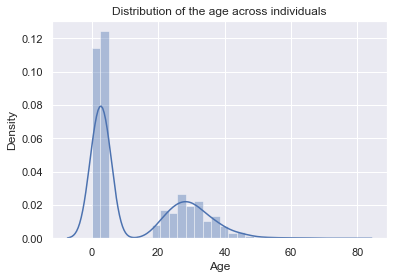

In [13]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set()
sns.distplot(individual['S_age'], bins = 30)
plt.title('Distribution of the age across individuals')
plt.xlabel('Age')
plt.show()

We will keep only individuals under 15 years old : apparently there is no or very few people between 10 and 20. It should represent at least half of the original data.

In [14]:
children = individual.query('S_age < 15')
print('There are', len(children.index),'children.')
print('How many missing values ?', children.isna().sum().sum())

There are 4093 children.
How many missing values ? 16867


### Creation of the target for future algorithm

In [15]:
health = ['S_parcount', 'S_diarrhea', 'S_anemia', 'S_respira', 'S_skin', 'S_otherdis']

def target(health):
    N = len(children.index)
    target = []
    for n in range(N):
        if individual[health].loc[n].sum() >= 1:
            target.append(1)
        else:
            target.append(0)
    return pd.DataFrame(target, columns = ['target'])

In [16]:
target = target(health)
N = len(target.index)
print(str(len(target.index))+' values, so there is no missing values in the target.')
sick = len(target[target['target'] == 1])/N*100
non_sick = len(target[target['target'] == 0])/N*100
print(str(sick)+"% of sick VS "+str(non_sick)+"% non sick.")

4093 values, so there is no missing values in the target.
44.24627412655754% of sick VS 55.75372587344246% non sick.


In [17]:
imputer = KNNImputer()
temp = imputer.fit(children[health])
target_2 = pd.DataFrame(temp.transform(children[health]))
target_2.columns = children[health].columns

In [18]:
children = children.drop(health, axis = 1)

In [19]:
target_2.head()

,S_parcount,S_diarrhea,S_anemia,S_respira,S_skin,S_otherdis
0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0
2,0.2,0.0,0.0,1.0,0.0,0.0
3,0.2,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0


### Missing values

In [20]:
print("Missing values per sample :")
print(children.isna().sum(axis = 1).sort_values(ascending = False))

Missing values per sample :
4517    8
6659    8
2142    8
6165    8
6051    8
       ..
5166    3
2464    3
2468    3
5158    3
3305    3
Length: 4093, dtype: int64


In [21]:
print("Missing values per feature :")
print(children.isna().sum().sort_values(ascending = False))

Missing values per feature :
S_malincom             4093
S_palincom             4092
S_mccdts               3492
S_pbdypct              2504
coord_x                 285
                       ... 
dtriage_4_35_male         0
dtriage_4_68_male         0
dtriage_4_911_male        0
dtriage_4_02_female       0
dpisofirme                0
Length: 83, dtype: int64


We can see that features 'S_malincom' and 'S_palincom' are almost empty. These features will be dropped, they don't bring any information. 'S_mccdts' and 'S_pbdypct' also contains many missing values (more than half is empty), they could have been interesting for our study but we don't think that imputation is a good thing to do with this quantity of missing values. 

In [22]:
children = children.drop(['S_malincom', 'S_palincom', 'S_mccdts', 'S_pbdypct'], axis = 1)

In [23]:
print("Missing values per feature :")
print(children.isna().sum().sort_values(ascending = False))

Missing values per feature :
coord_x                285
coord_y                285
S_childpaeduc          166
S_childpaage           156
S_haz                  135
                      ... 
dtriage_4_68_male        0
dtriage_4_911_male       0
dtriage_4_02_female      0
dtriage_4_35_female      0
dpisofirme               0
Length: 79, dtype: int64


'coord_x' and 'coord_y' are useless for our study : they kind of bias the prediction because they give direct information about control group and treatment group. Same can be said for 'idmun' and 'idmza'. Other features have an acceptable number of missing values, and we can see that there are no rows with a significant amount of missingness. We will try 2 techniques to impute these values : either with 0 either with a KNN imputer. 

In [24]:
children = children.drop(['coord_x', 'coord_y', 'idmun', 'idmza', 'idcluster'], axis = 1)

In [25]:
col = children.columns
to_del = [j for j in col if not j.startswith('dtriage')]
children = children[to_del]

### Imputation with 0

In [26]:
children_1 = children.fillna(value = 0)

In [27]:
print('How many missing values ?', children_1.isna().sum().sum())

How many missing values ? 0


### Imputation with KNN

In [28]:
imputer = KNNImputer()
temp = imputer.fit(children)
children_2 = pd.DataFrame(temp.transform(children))
children_2.columns = children.columns

In [29]:
feature = children_2.drop(['S_incomepc', 'S_cashtransfers', 'S_assetspc', 'S_haz', 'S_whz', 'dpisofirme'], axis = 1)
for f in feature:
    children_2[f] = children_2[f].apply(lambda x : int(x) if abs(int(x)-x)<0.5 else int(x+1))

In [30]:
print('How many missing values ?', children_2.isna().sum().sum())

How many missing values ? 0


### Normalization

In [31]:
#Only continuous features should be normalized
to_norm = ['S_age', 'S_childmaage', 'S_childmaeduc', 'S_childpaage', 'S_childpaeduc', 'S_HHpeople', 'S_rooms',
            'S_haz', 'S_whz', 'S_washhands', 'S_incomepc', 'S_cashtransfers', 'S_assetspc']
children_1[to_norm].describe()

,S_age,S_childmaage,S_childmaeduc,S_childpaage,S_childpaeduc,S_HHpeople,S_rooms,S_haz,S_whz,S_washhands,S_incomepc,S_cashtransfers,S_assetspc
count,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000
mean,2.615685,26.078182,6.620450,22.634254,5.169558,5.746152,2.044955,-0.582558,0.127313,3.725873,992.428955,12.716292,20934.103516
std,1.722299,8.610106,3.028355,14.904110,4.054854,2.227035,1.101821,1.092537,1.115147,1.500445,3342.383057,34.480537,7238.569336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-4.780000,-4.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,22.000000,6.000000,0.000000,0.000000,4.000000,1.000000,-1.290000,-0.550000,3.000000,496.666656,0.000000,15727.537109
50%,3.000000,26.000000,6.000000,26.000000,6.000000,5.000000,2.000000,-0.540000,0.060000,3.000000,700.000000,0.000000,21000.802734
75%,4.000000,31.000000,9.000000,32.000000,9.000000,7.000000,3.000000,0.080000,0.690000,4.000000,1028.571411,0.000000,26186.296875
max,14.000000,66.000000,16.000000,77.000000,16.000000,19.000000,10.000000,2.990000,4.940000,10.000000,127266.664062,950.000000,64594.199219


We can see that 'S_incomepc' and 'S_assetspc' are power law. We will apply a log(1+x) transformation on them to change the re-scale the distribution. Concerning 'S_cashtransfers' we will apply a $\sqrt(x)$ transformation to it to re-scale the distribution too.

In [32]:
children_1[['S_incomepc', 'S_assetspc']] = children_1[['S_incomepc', 'S_assetspc']].apply(lambda x : np.log(1+x))
children_2[['S_incomepc', 'S_assetspc']] = children_2[['S_incomepc', 'S_assetspc']].apply(lambda x : np.log(1+x))

children_1['S_cashtransfers'] = children_1['S_cashtransfers'].apply(lambda x : np.sqrt(x))
children_2['S_cashtransfers'] = children_2['S_cashtransfers'].apply(lambda x : np.sqrt(x))

In [33]:
mean = children_1[to_norm].mean(axis = 0)
std = children_1[to_norm].std(axis = 0)
children_1[to_norm] = (children_1[to_norm] - mean)/std

In [34]:
children_2[to_norm].describe()

,S_age,S_childmaage,S_childmaeduc,S_childpaage,S_childpaeduc,S_HHpeople,S_rooms,S_haz,S_whz,S_washhands,S_incomepc,S_cashtransfers,S_assetspc
count,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000,4093.000000
mean,2.615685,26.464940,6.723675,23.581481,5.375763,5.746152,2.044955,-0.600168,0.128313,3.725873,6.218493,1.599963,9.889759
std,1.722321,8.015598,2.920772,14.299701,3.941163,2.227047,1.101821,1.092005,1.119333,1.500442,1.715686,3.187300,0.354343
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-4.780000,-4.000000,0.000000,0.000000,0.000000,8.625981
25%,1.000000,22.000000,6.000000,20.000000,0.000000,4.000000,1.000000,-1.308000,-0.560000,3.000000,6.209930,0.000000,9.665103
50%,3.000000,26.000000,6.000000,27.000000,6.000000,5.000000,2.000000,-0.600000,0.090000,3.000000,6.552508,0.000000,9.952501
75%,4.000000,31.000000,9.000000,32.000000,9.000000,7.000000,3.000000,0.090000,0.710000,4.000000,6.936898,0.000000,10.173030
max,14.000000,66.000000,16.000000,77.000000,16.000000,19.000000,10.000000,2.990000,4.940000,10.000000,11.754048,30.822070,11.075895


In [35]:
mean = children_2[to_norm].mean(axis = 0)
std = children_2[to_norm].std(axis = 0)
children_2[to_norm] = (children_2[to_norm] - mean)/std

In [36]:
children_2[to_norm].describe()

,S_age,S_childmaage,S_childmaeduc,S_childpaage,S_childpaeduc,S_HHpeople,S_rooms,S_haz,S_whz,S_washhands,S_incomepc,S_cashtransfers,S_assetspc
count,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03,4.093000e+03
mean,2.135816e-16,-2.216649e-16,2.753180e-16,4.466118e-17,1.220621e-17,-7.500041e-16,2.863171e-16,-2.374516e-16,-6.303832e-17,-2.970450e-16,-4.002088e-14,4.714311e-17,6.437992e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.518698e+00,-3.301680e+00,-2.302020e+00,-1.649089e+00,-1.364004e+00,-2.580166e+00,-9.483888e-01,-3.827669e+00,-3.688190e+00,-2.483183e+00,-3.624493e+00,-5.019808e-01,-3.566541e+00
25%,-9.380858e-01,-5.570315e-01,-2.477683e-01,-2.504584e-01,-1.364004e+00,-7.840660e-01,-9.483888e-01,-6.481950e-01,-6.149316e-01,-4.837730e-01,-4.990439e-03,-5.019808e-01,-6.340090e-01
50%,2.231376e-01,-5.800442e-02,-2.477683e-01,2.390623e-01,1.583889e-01,-3.350409e-01,-4.080045e-02,1.539081e-04,-3.422861e-02,-4.837730e-01,1.946832e-01,-5.019808e-01,1.770654e-01
75%,8.037493e-01,5.657794e-01,7.793575e-01,5.887200e-01,9.195856e-01,5.630092e-01,8.667879e-01,6.320194e-01,5.196726e-01,1.826972e-01,4.187277e-01,-5.019808e-01,7.994247e-01
max,6.609866e+00,4.932266e+00,3.175984e+00,3.735639e+00,2.695711e+00,5.951310e+00,7.219906e+00,3.287686e+00,4.298709e+00,4.181518e+00,3.226438e+00,9.168295e+00,3.347425e+00


# Feature selection

### Pearson's correlation

In [37]:
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y, rowvar = False)[0, 1]
        cor_list.append(cor)
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature

In [38]:
cor_support_1, cor_feature_1 = cor_selector(children_1, target, 15)
print(str(len(cor_feature_1)), 'selected features')
print("Selected features :", cor_feature_1)

15 selected features
Selected features : ['S_childpaeduc', 'S_electricity', 'S_whz', 'S_childpa', 'S_childmaage', 'S_incomepc', 'S_childmaeduc', 'S_gender', 'S_waterland', 'dpisofirme', 'S_foodprogram', 'S_rooms', 'S_assetspc', 'S_seguropopular', 'S_HHpeople']


In [39]:
cor_support_2, cor_feature_2 = cor_selector(children_2, target, 15)
print(str(len(cor_feature_2)), 'selected features')
print("Selected features :", cor_feature_2)

15 selected features
Selected features : ['S_haz', 'S_whz', 'S_childpaage', 'S_childpa', 'S_childmaage', 'S_childmaeduc', 'S_incomepc', 'S_gender', 'S_waterland', 'dpisofirme', 'S_foodprogram', 'S_rooms', 'S_assetspc', 'S_seguropopular', 'S_HHpeople']


### Chi-2

In [40]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

def chi_2(X, y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    return chi_support, chi_feature

In [41]:
chi_support_1, chi_feature_1 = chi_2(children_1, target, 15)
print(str(len(chi_feature_1)), 'selected features')
print("Selected features :", chi_feature_1)

15 selected features
Selected features : ['dpisofirme', 'S_gender', 'S_childmaage', 'S_childmaeduc', 'S_childpa', 'S_childpaeduc', 'S_HHpeople', 'S_rooms', 'S_waterland', 'S_milkprogram', 'S_foodprogram', 'S_seguropopular', 'S_animalsinside', 'S_garbage', 'S_incomepc']


In [42]:
chi_support_2, chi_feature_2 = chi_2(children_2, target, 15)
print(str(len(chi_feature_2)), 'selected features')
print("Selected features :", chi_feature_2)

15 selected features
Selected features : ['dpisofirme', 'S_gender', 'S_childmaage', 'S_childmaeduc', 'S_childpa', 'S_childpaage', 'S_HHpeople', 'S_rooms', 'S_waterland', 'S_milkprogram', 'S_foodprogram', 'S_seguropopular', 'S_garbage', 'S_incomepc', 'S_assetspc']


In [43]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

def lightgbm(X, y, num_feat):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feat)
    embeded_lgb_selector.fit(X, y)

    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    return embeded_lgb_support, embeded_lgb_feature

In [44]:
embeded_lgb_support_1, embeded_lgb_feature_1 = lightgbm(children_1, target, 15)
print(str(len(embeded_lgb_feature_1)), 'selected features')
print("Selected features :", embeded_lgb_feature_1)

8 selected features
Selected features : ['S_childmaage', 'S_childmaeduc', 'S_childpaage', 'S_childpaeduc', 'S_haz', 'S_whz', 'S_incomepc', 'S_assetspc']


In [45]:
embeded_lgb_support_2, embeded_lgb_feature_2 = lightgbm(children_2, target, 15)
print(str(len(embeded_lgb_feature_2)), 'selected features')
print("Selected features :", embeded_lgb_feature_2)

9 selected features
Selected features : ['S_childmaage', 'S_childmaeduc', 'S_childpaage', 'S_childpaeduc', 'S_haz', 'S_whz', 'S_washhands', 'S_incomepc', 'S_assetspc']


### RFE

In [46]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

def rfe(X, y, num_feat):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(max_iter = 5000), n_features_to_select=num_feat, step=10, verbose=5)
    rfe_selector.fit(X_norm, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    return rfe_support, rfe_feature

In [47]:
rfe_support_1, rfe_feature_1 = rfe(children_1, target, 15)
print(str(len(rfe_feature_1)), 'selected features')
print("Selected features :", rfe_feature_1)

Fitting estimator with 26 features.
Fitting estimator with 16 features.
15 selected features
Selected features : ['S_age', 'S_childmaage', 'S_childmaeduc', 'S_childpa', 'S_childpaage', 'S_childpaeduc', 'S_HHpeople', 'S_rooms', 'S_whz', 'S_waterland', 'S_electricity', 'S_foodprogram', 'S_seguropopular', 'S_incomepc', 'S_assetspc']


In [48]:
rfe_support_2, rfe_feature_2 = rfe(children_2, target, 15)
print(str(len(rfe_feature_2)), 'selected features')
print("Selected features :", rfe_feature_2)

Fitting estimator with 26 features.
Fitting estimator with 16 features.
15 selected features
Selected features : ['S_age', 'S_childmaage', 'S_childmaeduc', 'S_childpaage', 'S_childpaeduc', 'S_HHpeople', 'S_rooms', 'S_whz', 'S_waterland', 'S_electricity', 'S_foodprogram', 'S_seguropopular', 'S_washhands', 'S_incomepc', 'S_assetspc']


### Random forest

In [49]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

def rf(X, y, num_feat):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feat)
    embeded_rf_selector.fit(X, y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    return embeded_rf_support, embeded_rf_feature

In [50]:
embeded_rf_support_1, embeded_rf_feature_1 = rf(children_1, target, 15)
print(str(len(embeded_rf_feature_1)), 'selected features')
print("Selected features :", embeded_rf_feature_1)

10 selected features
Selected features : ['S_age', 'S_childmaage', 'S_childmaeduc', 'S_childpaage', 'S_childpaeduc', 'S_haz', 'S_whz', 'S_washhands', 'S_incomepc', 'S_assetspc']


In [51]:
embeded_rf_support_2, embeded_rf_feature_2 = rf(children_2, target, 15)
print(str(len(embeded_rf_feature_2)), 'selected features')
print("Selected features :", embeded_rf_feature_2)

10 selected features
Selected features : ['S_age', 'S_childmaage', 'S_childmaeduc', 'S_childpaage', 'S_childpaeduc', 'S_haz', 'S_whz', 'S_washhands', 'S_incomepc', 'S_assetspc']


### Lasso regularization

In [52]:
from sklearn.linear_model import LassoCV, Lasso

def lasso(X, y):
    reg = LassoCV()
    reg_ = reg.fit(X, y)
    print("Best alpha using built-in LassoCV: %f" % reg_.alpha_)
    print("Best score using built-in LassoCV: %f" %reg_.score(X, y))
    coef = pd.Series(reg_.coef_, index = X.columns)
    print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  
          str(sum(coef == 0)) + " variables")
    sns.set()
    imp_coef = coef.sort_values()
    import matplotlib
    matplotlib.rcParams['figure.figsize'] = (5, 5)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using Lasso Model")
    plt.show()

    kept = imp_coef[[imp_coef[i] != 0 for i in range(len(imp_coef))]]
    lasso_feature = [(i in kept) for i in X.columns]
    lasso_support = X.columns.tolist()
    return lasso_support, lasso_feature

Best alpha using built-in LassoCV: 0.017083
Best score using built-in LassoCV: 0.000000
Lasso picked 1 variables and eliminated the other 25 variables


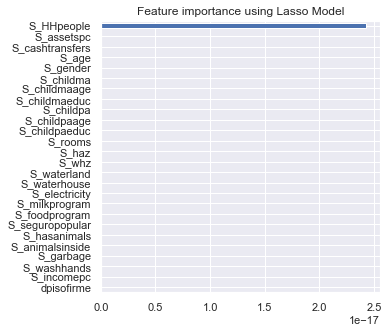

In [53]:
lasso_support_1, lasso_feature_1 = lasso(children_1, target)

Best alpha using built-in LassoCV: 0.017083
Best score using built-in LassoCV: 0.000000
Lasso picked 1 variables and eliminated the other 25 variables


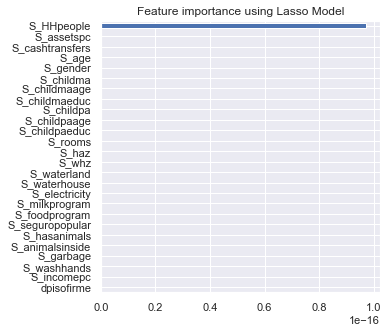

In [54]:
lasso_support_2, lasso_feature_2 = lasso(children_2, target)

In [55]:
# put all selection together
feature_selection_df_1 = pd.DataFrame({'Feature':children_1.columns, 'Pearson':cor_support_1, 'Chi-2':chi_support_1, 'RFE':rfe_support_1,
                                    'Random Forest':embeded_rf_support_1, 'LightGBM':embeded_lgb_support_1, 'Lasso':lasso_feature_1})
# count the selected times for each feature
feature_selection_df_1['Total'] = np.sum(feature_selection_df_1, axis=1)
# display the top 100
feature_selection_df_1 = feature_selection_df_1.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df_1.index = range(1, len(feature_selection_df_1)+1)
feature_selection_df_1.head(30)

,Feature,Pearson,Chi-2,RFE,Random Forest,LightGBM,Lasso,Total
1,S_incomepc,True,True,True,True,True,False,5
2,S_childpaeduc,True,True,True,True,True,False,5
3,S_childmaeduc,True,True,True,True,True,False,5
4,S_childmaage,True,True,True,True,True,False,5
5,S_whz,True,False,True,True,True,False,4
6,S_assetspc,True,False,True,True,True,False,4
7,S_HHpeople,True,True,True,False,False,True,4
8,S_waterland,True,True,True,False,False,False,3
9,S_seguropopular,True,True,True,False,False,False,3
10,S_rooms,True,True,True,False,False,False,3


In [56]:
# put all selection together
feature_selection_df_2 = pd.DataFrame({'Feature':children_2.columns, 'Pearson':cor_support_2, 'Chi-2':chi_support_2, 'RFE':rfe_support_2,
                                    'Random Forest':embeded_rf_support_2, 'LightGBM':embeded_lgb_support_2, 'Lasso':lasso_feature_2})
# count the selected times for each feature
feature_selection_df_2['Total'] = np.sum(feature_selection_df_2, axis=1)
# display the top 100
feature_selection_df_2 = feature_selection_df_2.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df_2.index = range(1, len(feature_selection_df_2)+1)
feature_selection_df_2.head(30)

,Feature,Pearson,Chi-2,RFE,Random Forest,LightGBM,Lasso,Total
1,S_incomepc,True,True,True,True,True,False,5
2,S_childpaage,True,True,True,True,True,False,5
3,S_childmaeduc,True,True,True,True,True,False,5
4,S_childmaage,True,True,True,True,True,False,5
5,S_assetspc,True,True,True,True,True,False,5
6,S_whz,True,False,True,True,True,False,4
7,S_HHpeople,True,True,True,False,False,True,4
8,S_waterland,True,True,True,False,False,False,3
9,S_washhands,False,False,True,True,True,False,3
10,S_seguropopular,True,True,True,False,False,False,3


# Logistic regression

In [57]:
#Select the 15th first features
features = feature_selection_df_1['Feature'][:14]
features_list = features.tolist()
children_1['target'] = target

print(features)

1          S_incomepc
2       S_childpaeduc
3       S_childmaeduc
4        S_childmaage
5               S_whz
6          S_assetspc
7          S_HHpeople
8         S_waterland
9     S_seguropopular
10            S_rooms
11      S_foodprogram
12       S_childpaage
13          S_childpa
14         dpisofirme
Name: Feature, dtype: object


In [58]:
#Building the model and fitting the data 
log_reg = smf.logit(formula = 'target ~ C(dpisofirme) + S_childmaage + \
                    S_childmaeduc + C(S_childpa) + S_childpaage + S_childpaeduc + \
                    S_HHpeople + S_rooms + S_whz + C(S_waterland) + \
                    C(S_foodprogram) + \
                    C(S_seguropopular) + \
                    + S_incomepc + S_assetspc', data = children_1)
res = log_reg.fit()
print(res.summary())
#selected_features=features[log_reg.pvalues.apply(lambda x: x<0.05 ).to_numpy()]

Optimization terminated successfully.
         Current function value: 0.591310
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 2522
Model:                          Logit   Df Residuals:                     2507
Method:                           MLE   Df Model:                           14
Date:                Wed, 09 Dec 2020   Pseudo R-squ.:                0.005796
Time:                        22:17:41   Log-Likelihood:                -1491.3
converged:                       True   LL-Null:                       -1500.0
Covariance Type:            nonrobust   LLR p-value:                    0.2361
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     1.0102      0.354      2.853      0.004       0.

In [59]:
selected_features

4    S_childmaage
8     S_waterland
Name: Feature, dtype: object

In [60]:
#With all the features
features = children_1.columns
features_list = features.tolist()
x_tr, x_te, y_tr, y_te = train_test_split(children_1, np.ravel(target), test_size = 0.3, random_state = 50)

#Building the model and fitting the data 
log_reg = sm.Logit(y_tr, x_tr).fit() 
print(log_reg.summary())
selected_features=features[log_reg.pvalues.apply(lambda x: x<0.05 ).to_numpy()]

Optimization terminated successfully.
         Current function value: 0.682666
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2865
Model:                          Logit   Df Residuals:                     2839
Method:                           MLE   Df Model:                           25
Date:                Wed, 09 Dec 2020   Pseudo R-squ.:                0.005641
Time:                        21:54:00   Log-Likelihood:                -1955.8
converged:                       True   LL-Null:                       -1966.9
Covariance Type:            nonrobust   LLR p-value:                    0.6246
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
dpisofirme          0.0101      0.077      0.131      0.896      -0.140       0.161
S_age         

# Try this disease by disease

In [65]:
signi = []
for f in target_2:
    print(target_2[f])
    #With all the features
    features = children_1.columns
    features_list = features.tolist()
    x_tr, x_te, y_tr, y_te = train_test_split(children_1, target_2[f], test_size = 0.3, random_state = 50)

    #Building the model and fitting the data 
    log_reg = sm.Logit(y_tr, x_tr).fit() 
    selected_features=features[log_reg.pvalues.apply(lambda x: x<0.05 ).to_numpy()]
    signi.append(selected_features)
print(signi)

0       0.0
1       0.0
2       0.2
3       0.2
4       0.0
       ... 
4088    2.0
4089    0.0
4090    0.0
4091    0.0
4092    1.0
Name: S_parcount, Length: 4093, dtype: float64


ValueError: The indices for endog and exog are not aligned